<a href="https://colab.research.google.com/github/Sreerag-ibtl/damage-identification-from-tweets-using-multimodal-learning/blob/master/Copy_of_damge_identification_from_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>















# Global imports

In [ ]:
%tensorflow_version 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:

import os
import subprocess
import cv2
import numpy as np

from google.colab import drive
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import string
import re
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout, Concatenate, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
import tensorflow as tf

import tensorflow_hub as hub

from sklearn.utils import class_weight

import zipfile

# Globals

In [ ]:
DIR       = "/content"
ZIP       = "multimodal-deep-learning-disaster-response-mouzannar.zip"
UNZIP     = "multimodal"
DATA      = "data"
CLASSES   = [ "damage", "non-damage" ]
DRIVE     = "gdrive"
IMG_MODEL = "/content/gdrive/My Drive/rapid_projects/damage_identification_from_tweets/damage.h5"
TXT_MODEL = "/content/gdrive/My Drive/rapid_projects/text.h5"

# Download dataset.

In [ ]:
#Downloading dataset.
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00456/multimodal-deep-learning-disaster-response-mouzannar.zip

--2020-06-05 07:46:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00456/multimodal-deep-learning-disaster-response-mouzannar.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132451409 (1.1G) [application/x-httpd-php]
Saving to: ‘multimodal-deep-learning-disaster-response-mouzannar.zip’

multimodal-deep-lea 100%[===================>]   1.05G  42.1MB/s    in 27s     

2020-06-05 07:46:30 (40.4 MB/s) - ‘multimodal-deep-learning-disaster-response-mouzannar.zip’ saved [1132451409/1132451409]



In [ ]:
!unzip $ZIP

Streaming output truncated to the last 5000 lines.
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-27-53.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-28-53.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-29-00.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-29-03.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-29-07.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-29-24.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-30-20.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-30-52.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-31-19.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-31-43.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-32-30.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-33-04.jpg  
  inflating: multimodal/non_damage/images/ad_2017-11-25_06-33-13.jpg  
  inflating: multimodal/no

In [ ]:
!rm $ZIP

# Save the files inside out.

We will walk through each directory and move it to another directory

In [ ]:
def move( from_path, def_class, to_path, keyword ):
    """A function that moves files from one directory to other."""

    modalities = os.listdir( os.path.join( from_path, def_class ) )
    for modality in modalities:
        filenames = os.listdir( os.path.join( from_path, def_class, modality ) )
        for filename in filenames:
          os.rename( os.path.join( from_path, def_class, modality, filename ), os.path.join( to_path, keyword, filename ) )    

def create_new_dir( from_path, to_path, classes ):
  """A function that dumps all files into one directory."""

  os.mkdir( to_path )
  for cls in classes:
    os.mkdir( os.path.join( to_path, cls ) )

  from_paths = os.listdir( from_path )
  
  for def_class in from_paths:
    if def_class != "non_damage":
      move( from_path, def_class, to_path, "damage" )
    else:
      move( from_path, def_class, to_path, "non-damage" ) 

In [ ]:
create_new_dir( UNZIP, DATA, CLASSES )

In [ ]:
!rm -rf UNZIP

# Load trained models.

Mount drive.

In [ ]:
drive.mount( DRIVE )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [ ]:
model_text  = load_model( TXT_MODEL, custom_objects = { "KerasLayer" : hub.KerasLayer } )
model_image = load_model( IMG_MODEL )

OSError: ignored

# Store features.

In [ ]:

        im_class  = np.argmax( im_preds )
        txt_preds = self.text_model.predict( text )
        txt_class = np.argmax( txt_preds )

        return im_preds, txt_preds

    def preprocess_image( self, image ):

        image = cv2.resize( class FeatureExtractor:
    """A class that implements prediction."""
    
    def __init__( self, text_model_path, image_model_path  ):

        self.text_model  = load_model( text_model_path, custom_objects={"KerasLayer":hub.KerasLayer} )
        self.image_model = load_model( image_model_path, )

    def run( self, image, text ):

        image = self.preprocess_image( image )
        text  = self.preprocess_text( text ) 

        im_preds  = self.image_model.predict( image )image, ( 299, 299 ) )
        image = image / 255.
        image = np.expand_dims( image, axis = 0 )
        return image

    def preprocess_text( self, text ):

        text = re.sub( "[#=_()~:,@./+!?|]", "", text )
        text = re.sub( "[^A-Za-z0-9\x00-\x7F]+", "", text)
        text = text.replace( "\n", "" )
        text = text.lower( )
        text = text.encode()
        text = np.array( text )
        text = np.expand_dims( text, 0 )
        text = tf.convert_to_tensor( text )
        return text

IndentationError: ignored

In [ ]:
def featurify_both(path,image_model,text_model):
  classes=["damage","non-damage"]
  images=[]
  texts=[]
  class_list=[]
  for subdir_0 in os.listdir(path):
    #for subdir_1 in os.listdir(os.path.join(path,subdir_0)):
    if subdir_0 !=
    for filename in os.listdir(os.path.join(path,subdir_0,"images")):
      basename=filename.split(".")[0]
      ext=filename.split(".")[1]
      #if ext!="txt":
      try:
        image=cv2.imread(os.path.join(path,subdir_0,subdir_1,"images",filename))
        image=cv2.resize(image,(299,299))
        image=image/255.
        image=np.expand_dims(image,0)
        img_ft=image_model.predict(image)
        with open(os.path.join(path,subdir_0,subdir_1,"text",basename+".txt") as text_file:
          text = tfile.read( )

SyntaxError: ignored

First of all, the images has to be converted to TensorFlow's native data file format TF-Records. For that, the images should be arranged in the following directory structure.

In [ ]:
#Name of the parent directory is set to 'dataset'. Creating 'dataset'.
!mkdir dataset

In [ ]:
!mkdir dataset/damage

In [ ]:
def move_files_from( here, to_here ) :

  for dir in os.listdir( here ) :

    if dir != "non_damage" :

      for file in os.listdir( os.path.join( here, dir, "images" ) ) :
        
        #print( os.path.join( here, dir, "images", file ), os.path.join( to_here, "damage", file ) )

        os.rename( os.path.join( here, dir, "images", file ), os.path.join( to_here, "damage", file ) )
        
    else :

      print( os.path.join( here, "non_damage", "images" ), os.path.join( to_here, "non_damage" ) )

      os.rename( os.path.join( here, "non_damage", "images" ), os.path.join( to_here, "non_damage" ) )

In [ ]:
here = "/content/multimodal"
to_here = "/content/dataset"

In [ ]:
move_files_from( here, to_here )

/content/multimodal/non_damage/images /content/dataset/non_damage


FileNotFoundError: ignored

In [ ]:
def print_num_imgs_in_each_class_in( dataset ) :

  for each_class in os.listdir( dataset ) :

    print( each_class )
    print( " ", len( os.listdir( os.path.join( dataset, each_class ) ) ) ) 

In [ ]:
print_num_imgs_in_each_class_in( "/content/dataset" )

non_damage
  0
damage
  0


In [ ]:
base_model = InceptionV3( input_shape = ( 299, 299, 3 ), weights = 'imagenet', include_top = False )

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
base_model.summary( )

In [ ]:
for index, layer in enumerate( base_model.layers ) :

  if index < 100 :
    layer.trainable = False
  else :
    layer.trainable = True

In [ ]:
base_model.summary( )

In [ ]:
input = base_model.input

x = base_model.output
x = AveragePooling2D( ( 8, 8 ) )( x )
x = Dropout( 0.4 )( x )
x = Flatten( )( x )

predictions = Dense( 2, activation = "softmax" )( x )

model = Model( inputs = input, outputs = predictions )

In [ ]:
model.summary()

In [ ]:
model.compile( loss = "categorical_crossentropy", optimizer = "rmsprop", metrics = [ 'accuracy' ] )

In [ ]:
names = [ "damage", "non_damage" ]

for item in os.listdir( to_here ) :

  if item not in names :

    print( item )

    os.rmdir( os.path.join( to_here, item ) )

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

#train_datagen = ImageDataGenerator( )

In [ ]:
validation_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

#validation_datagen = ImageDataGenerator( )

In [ ]:
train_generator = train_datagen.flow_from_directory(
			"dataset",
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)

Found 5879 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'damage': 0, 'non_damage': 1}

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
			"dataset",
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)

Found 5879 images belonging to 2 classes.


In [ ]:
validation_generator.class_indices

{'damage': 0, 'non_damage': 1}

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
class_weights = class_weight.compute_class_weight( "balanced", np.unique( train_generator.classes ), train_generator.classes )

In [ ]:
class_weights

array([1.01117991, 0.9890646 ])

In [ ]:
callback = EarlyStopping( patience = 0 )

In [ ]:
history = model.fit_generator( train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              class_weight = class_weights,
                              callbacks = [ callback ] ) 

"""history = model.fit_generator( train_generator,
                              epochs=1,
                              class_weight = class_weights ) """

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 184 steps, validate for 184 steps
Epoch 1/10
184/184 [==============================] - 449s 2s/step - loss: 0.5280 - accuracy: 0.7597 - val_loss: 11.1324 - val_accuracy: 0.5190
Epoch 2/10
184/184 [==============================] - 429s 2s/step - loss: 0.3674 - accuracy: 0.8422 - val_loss: 94.0731 - val_accuracy: 0.5156


'history = model.fit_generator( train_generator,\n                              epochs=1,\n                              class_weight = class_weights ) '

In [ ]:
model.save( 'damage.h5' )

In [ ]:
from google.colab import drive
drive.mount( "gdrive" )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [ ]:
mv /content/damage.h5 "/content/gdrive/My Drive/rapid_projects"

In [ ]:
from google.colab import drive
drive.mount( "gdrive" )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [ ]:
from_here = "/content/gdrive/My Drive/rapid_projects/damage_identification_from_tweets/damage.h5"

In [ ]:
model = load_model( from_here )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
def category_and_proba_of( image_from_here, model ) :

  image = cv2.imread( image_from_here )
  image = cv2.resize( image, ( 299, 299 ) )
  image = image / 255.
  image_enclosed = np.expand_dims( image, axis = 0 )

  output_from_softmax_is = model.predict( image_enclosed )
  print( output_from_softmax_is )
  print( output_from_softmax_is.shape )

  category = np.argmax( output_from_softmax_is )
  probability = np.max( output_from_softmax_is )

  return category, probability

# New Section

In [ ]:
image_from_here = "/content/261118,xcitefun-relaxing-nature-scene.jpg"

category, probability = category_and_proba_of( image_from_here, model )

[[0.14641228 0.85358775]]
(1, 2)


In [ ]:
category, probability

(1, 0.85358775)

In [ ]:
history.history

{'accuracy': [0.75965303, 0.84215003],
 'loss': [0.52837059481206, 0.3676817782488095],
 'val_accuracy': [0.5189658, 0.51556385],
 'val_loss': [11.13244267391122, 94.07307705671892]}

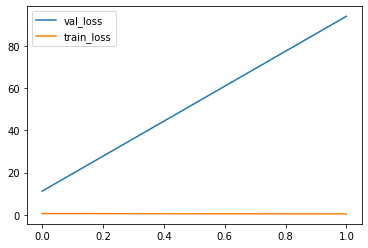

In [ ]:
import matplotlib.pyplot as plt

plt.plot( history.history[ "val_loss" ] )
plt.plot( history.history[ "loss" ] )

plt.legend( ( "val_loss", "train_loss" ) )

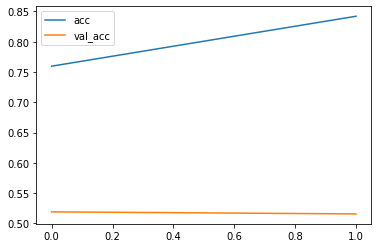

In [ ]:
plt.plot( history.history[ "accuracy" ] )
plt.plot( history.history[ "val_accuracy" ] )
plt.legend(("acc","val_acc"))

In [ ]:
!mkdir dt

mkdir: cannot create directory ‘dt’: File exists


In [ ]:
def move_text_files( from_here, to_here ) :

  try :
    os.mkdir( to_here )

  except Exception as FileExistsError :
    
    try :
      os.mkdir( os.path.join( to_here, "damage" ) )

    except Exception as FileExistsError :

      print( "{0}/damage already exists".format( to_here ) )      
      if len( os.listdir( os.path.join( to_here, "damage" ) ) ) > 0 :
        return

  for dir in os.listdir( from_here ) :

    if dir != "non_damage" :

      for file in os.listdir( os.path.join( from_here, dir, "text" ) ) :        
        #print( os.path.join( from_here, dir, "text", file ))
        #print( os.path.join( to_here, "damage", file))
        os.rename( os.path.join( from_here, dir, "text", file ), os.path.join( to_here, "damage", file) )

    else :

      print( os.path.join( from_here, dir, "text" ) )
      print( os.path.join( to_here, dir ) )
      os.rename( os.path.join( from_here, dir, "text" ), os.path.join( to_here, dir ) )

move_text_files( "/content/multimodal", "/content/dt" )

/content/multimodal/non_damage/text
/content/dt/non_damage


In [ ]:
len( os.listdir( "/content/dt/damage" ) )

2874

In [ ]:
len( os.listdir( "/content/dt/non_damage" ) )

2957

In [ ]:
import re

In [ ]:

def return_data( path ):
  data = []
  label = []
  for sub_dir in os.listdir(path):
    for text_file in os.listdir( os.path.join( path, sub_dir ) ) :

      text_file = os.path.join( path, sub_dir, text_file )

      with open( text_file, "r" ) as tfile :
        text = tfile.read( )
        text = re.sub( "[#=_()~:,@./+!?|]", "", text )
        text = re.sub( "[^A-Za-z0-9\x00-\x7F]+", "", text)
        text = text.replace( "\n", "" )
        text = text.lower( )
        text = text.encode()
        #print( text )
        #print( )
        data.append( text )
        if sub_dir == "damage":
          label.append(0)
        else:
          label.append(1)
  data=np.array(data,dtype=object)
  label=np.array(label,dtype=np.int64)
      
  return data, label

In [ ]:
#damage = return_data( "/content/dataset/damage" )

In [ ]:
#non_damage = return_data( "/content/dataset/non_damage" )

In [ ]:
train_x, train_y=return_data( "/content/dt" )

In [ ]:
#train_x = np.expand_dims( train_x, 0 )
#train_y = np.expand_dims( train_y, 0 )

In [ ]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
train_y.shape

(5831,)

In [ ]:
train_x=tf.convert_to_tensor( train_x )
train_y=tf.convert_to_tensor( train_y )

In [ ]:
hub_layer(train_x[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 2.211101  ,  0.20460553, -1.2334579 , -0.6709212 ,  0.7275658 ,
        -0.501583  , -1.416808  ,  1.6828272 ,  0.41224945, -2.198472  ,
        -1.1625384 ,  3.3571577 ,  0.6423906 , -0.5830861 , -0.8003493 ,
         1.3500307 ,  2.1195984 , -1.5188466 , -1.899914  , -1.8085711 ],
       [ 0.48662883,  0.49422318,  0.60967886, -0.13495447,  0.08034506,
        -0.3434806 ,  0.19954544,  0.24668674, -0.32711574,  0.14693469,
        -0.3663859 ,  0.33904922, -0.9692243 , -0.20179863, -0.5382171 ,
         0.33991277,  0.10411987,  0.43654358, -0.14174107,  0.36365917],
       [ 0.9264073 , -1.4646924 ,  1.2321527 ,  1.7269675 , -1.892847  ,
        -1.717191  , -0.64931136,  0.81758165,  1.2027315 , -0.5681105 ,
        -1.5500008 ,  0.5502744 , -0.7681211 ,  0.3404802 , -1.8296554 ,
         0.2811705 ,  1.6178988 , -0.72293854, -1.0926514 , -0.98755866]],
      dtype=float32)>

In [ ]:
model = Sequential()
model.add( hub_layer )
model.add( Dense( 16, activation="relu" ) )
model.add( Dense( 2, activation="softmax" ) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 400,390
Trainable params: 400,390
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )

In [ ]:
history=model.fit( train_x, train_y, epochs=10, batch_size=20, validation_split=0.33  )

Train on 3906 samples, validate on 1925 samples
Epoch 1/10
3906/3906 [==============================] - 2s 385us/sample - loss: 0.4953 - accuracy: 0.7570 - val_loss: 0.8211 - val_accuracy: 0.5013
Epoch 2/10
3906/3906 [==============================] - 1s 302us/sample - loss: 0.2539 - accuracy: 0.8984 - val_loss: 0.6101 - val_accuracy: 0.6556
Epoch 3/10
3906/3906 [==============================] - 1s 272us/sample - loss: 0.1953 - accuracy: 0.9217 - val_loss: 0.5230 - val_accuracy: 0.7138
Epoch 4/10
3906/3906 [==============================] - 1s 290us/sample - loss: 0.1611 - accuracy: 0.9352 - val_loss: 0.4489 - val_accuracy: 0.7595
Epoch 5/10
3906/3906 [==============================] - 1s 288us/sample - loss: 0.1361 - accuracy: 0.9432 - val_loss: 0.4129 - val_accuracy: 0.7995
Epoch 6/10
3906/3906 [==============================] - 1s 314us/sample - loss: 0.1163 - accuracy: 0.9514 - val_loss: 0.5008 - val_accuracy: 0.7527
Epoch 7/10
3906/3906 [==============================] - 1s 291us

In [ ]:
model.save("text.h5")

In [ ]:
!mv "text.h5" "/content/gdrive/My Drive/rapid_projects"

In [ ]:
from google.colab import drive
drive.mount("gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [ ]:
model.input

<tf.Tensor 'keras_layer_1_input:0' shape=(None,) dtype=string>

In [ ]:
def num_words_per_sample(damage):
  words=[]
  for sentence in damage:
    each_words=sentence.split()
    for each_word in each_words:
      words.append(each_word)
  #plt.hist(words)
  len_words=len(words)
  len_unique=len(set(words))
  return words, len_words, len_unique
words, len_words, len_unique = num_words_per_sample(damage)

In [ ]:
a=plt.hist([words],50)


In [ ]:
!curl -L "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed" --output "sentence_encoder"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  745M  100  745M    0     0  87.0M      0  0:00:08  0:00:08 --:--:-- 68.7M


In [ ]:
model_text=load_model("/content/gdrive/My Drive/rapid_projects/text.h5", custom_objects={"KerasLayer":hub.KerasLayer})

In [ ]:
model_text.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model_image=load_model("/content/gdrive/My Drive/rapid_projects/damage.h5")

In [ ]:
model_image.summary()

In [ ]:
input_1=model_text.output
input_2=model_image.output

In [ ]:
input_1

In [ ]:
input_2

In [ ]:
c=Concatenate(name="concat_mine")([input_1,input_2])

In [ ]:
x=Flatten(name="flatten_mine")(c)

In [ ]:
x=Dense(32,activation="relu",name="dense_mine_0")(x)

In [ ]:
x=Dense(2,activation="softmax",name="dense_mine_1")(x)

In [ ]:
model_mixed=Model(inputs=[model_text.input,model_image.input],outputs=[x])

In [ ]:
model_mixed.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
model_mixed.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
model_mixed.outputs

[<tf.Tensor 'dense_mine_1/Identity:0' shape=(None, 1) dtype=float32>]

In [ ]:
model_image.trainable=False

In [ ]:
model_text.trainable=False

In [ ]:
train_y_=train_y

In [ ]:
for i in range(31):
  train_y_=np.expand_dims(train_y_,0)

In [ ]:
train_generator.next()[0].shape

(32, 299, 299, 3)

In [ ]:
history=model_mixed.fit(x=[train_x,train_generator.next()[0]],y=[train_y],shuffle=True)

ValueError: ignored

In [ ]:
train_x.shape

TensorShape([5831])

In [ ]:
train_y.shape

TensorShape([5831])

In [ ]:
train_generator.next()[0].shape

(32, 299, 299, 3)

In [ ]:
damag_old=load_model("/content/gdrive/My Drive/rapid_projects/damage_identification_from_tweets/damage.h5")

In [ ]:
damag_old.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
image_old=load_model("/content/gdrive/My Drive/rapid_projects/damage_identification_from_tweets/image.h5")

In [ ]:
image_old.summary()

In [ ]:
damag_old

In [ ]:
def featurify_both(path,image_model,text_model):
  classes=["damage","non-damage"]
  image_features=[]
  text_features=[]
  class_list=[]
  for subdir_0 in os.listdir(path):
    #for subdir_1 in os.listdir(os.path.join(path,subdir_0)):
    for filename in os.listdir(os.path.join(path,subdir_0,"images")):
      basename=filename.split(".")[0]
      ext=filename.split(".")[1]
      #if ext!="txt":
      try:
        image=cv2.imread(os.path.join(path,subdir_0,subdir_1,"images",filename))
        image=cv2.resize(image,(299,299))
        image=image/255.
        image=np.expand_dims(image,0)
        img_ft=image_model.predict(image)
        with open(os.path.join(path,subdir_0,subdir_1,"text",basename+".txt") as text_file:
          text = tfile.read( )
          text = re.sub( "[#=_()~:,@./+!?|]", "", text )
          text = re.sub( "[^A-Za-z0-9\x00-\x7F]+", "", text)
          text = text.replace( "\n", "" )
          text = text.lower( )
          text = text.encode()
          text = tf.convert_to_tensor(text)
          text_ft = text_model.predict( text )
        image_features.append(img_ft)
        text_features.append(text_ft)
  image_features=np.array(image_features)
  text_features=np.array(text_features)
  return image_features,text_features

In [ ]:
def featurify(path):
  classes=["damage","non-damge"]
  image_features=[]
  class_list=[]
  text_features=[]
  for sub_dir in os.listdir(path):
    for filename in os.listdir(os.path.join(path,sub_dir)):
      image=cv2.imread(os.path.join(path,sub_dir,filename))
      try:
        image=cv2.resize(image,(299,299))
        image=image/255.
        image=np.expand_dims(image,0)
        ft=damag_old.predict(image)
        image_features.append(ft)
        class_list.append(classes.index(sub_dir))
      except:
        pass
  return np.array(image_features),np.array(image_classes)

In [ ]:
img_fts,img_cls=featurify("/content/dataset")

In [ ]:
img_fts.shape

(5879, 1, 2)